### Hamiltonian Neural Network

\begin{equation}
\frac{d\mathbf{q}}{dt} ~=~ \frac{\partial \mathcal{H}}{\partial \mathbf{p}}, \quad \frac{d\mathbf{p}}{dt} ~= - \frac{\partial \mathcal{H}}{\partial \mathbf{q}}
\label{eq:eqn1}
\tag{1}
\end{equation}

- Naive approach for solving dynamics using NN is to directly predict the next position, momentum of a particle. $(p', q')$
- In HNN, instead, we minimize the objective: 
\begin{equation}
 \operatorname*{argmin}_\theta \bigg \Vert \frac{d\mathbf{q}}{dt} - \frac{\partial \mathcal{H_{\theta}}}{\partial \mathbf{p}} \bigg \Vert^2 ~+~ \bigg \Vert \frac{d\mathbf{p}}{dt} + \frac{\partial \mathcal{H_{\theta}}}{\partial \mathbf{q}} \bigg \Vert^2
\end{equation}

In [1]:
import torch
import numpy as np
import os

from data import get_dataset
import argparse

In [2]:
class HNN(torch.nn.Module):
    def __init__(self, hamiltonian=False):
        super(HNN, self).__init__()
        self.hamiltonian = hamiltonian
        
        if hamiltonian:
            output_dim=1
        else:
            output_dim=2
        self.linear1 = torch.nn.Linear(2, 200)
        self.linear2 = torch.nn.Linear(200, 200)
        self.linear3 = torch.nn.Linear(200, output_dim, bias=None)
        self.tanh = torch.tanh

    def forward(self, x):
        h = self.tanh( self.linear1(x) )
        h = self.tanh( self.linear2(h) )
        return self.linear3(h)

    def rk4_time_derivative(self, x, dt=0.01):
        return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)

    def time_derivative(self, x, t=None):

        if not self.hamiltonian:
            return self.forward(x)

        H = self.forward(x) # traditional forward pass

        dH = torch.autograd.grad(H.sum(), x, create_graph=True)[0] # gradients for solenoidal field
        dpdq = dH @ torch.FloatTensor([[0, 1],[-1, 0]])

        return dpdq


In [3]:
def rk4(fun, y0, t, dt, *args, **kwargs):
    dt2 = dt / 2.0
    k1 = fun(y0, t, *args, **kwargs)
    k2 = fun(y0 + dt2 * k1, t + dt2, *args, **kwargs)
    k3 = fun(y0 + dt2 * k2, t + dt2, *args, **kwargs)
    k4 = fun(y0 + dt * k3, t + dt, *args, **kwargs)
    dy = dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
    return dy

def L2_loss(u, v):
    return (u-v).pow(2).mean()

In [4]:
model = HNN(hamiltonian=False)
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [5]:
# arrange data
data = get_dataset()
x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt = torch.Tensor(data['dx'])
test_dxdt = torch.Tensor(data['test_dx'])

In [6]:
data['x'].shape

(750, 2)

In [7]:
data['x'][:5]

array([[-0.08470211,  0.8053172 ],
       [ 0.40116634,  0.52705736],
       [ 0.29779712,  0.53407765],
       [ 0.67702268,  0.38078621],
       [ 0.68412798,  0.21073979]])

In [8]:
use_rk4 = False
# vanilla train loop
stats = {'train_loss': [], 'test_loss': []}
for step in range(2000):
    # train step
    dxdt_hat = model.rk4_time_derivative(x) if use_rk4 else model.time_derivative(x)
    loss = L2_loss(dxdt, dxdt_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()

    # run test data
    test_dxdt_hat = model.rk4_time_derivative(test_x) if use_rk4 else model.time_derivative(test_x)
    test_loss = L2_loss(test_dxdt, test_dxdt_hat)

    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
    if step % 200 == 0:
        print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

step 0, train_loss 7.4635e-01, test_loss 5.0590e-01
step 200, train_loss 3.7029e-02, test_loss 3.6439e-02
step 400, train_loss 3.6905e-02, test_loss 3.6428e-02
step 600, train_loss 3.6851e-02, test_loss 3.6418e-02
step 800, train_loss 3.6822e-02, test_loss 3.6426e-02
step 1000, train_loss 3.6803e-02, test_loss 3.6442e-02
step 1200, train_loss 3.6785e-02, test_loss 3.6462e-02
step 1400, train_loss 3.6767e-02, test_loss 3.6489e-02
step 1600, train_loss 3.6754e-02, test_loss 3.6512e-02
step 1800, train_loss 3.6747e-02, test_loss 3.6530e-02


In [9]:
train_dxdt_hat = model.time_derivative(x)
# train_dxdt_hat = model.rk4_time_derivative(x)
train_dist = (dxdt - train_dxdt_hat)**2
test_dxdt_hat = model.time_derivative(test_x)
# test_dxdt_hat = model.rk4_time_derivative(test_x)
test_dist = (test_dxdt - test_dxdt_hat)**2
print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
.format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
        test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

Final train loss 3.6743e-02 +/- 1.9014e-03
Final test loss 3.6544e-02 +/- 1.8640e-03


In [10]:
# save
save_dir = './save'
os.makedirs(save_dir) if not os.path.exists(save_dir) else None
path = '{}/{}.tar'.format(save_dir, 'spring-baseline')
torch.save(model.state_dict(), path)

#### Train HNN

In [11]:
model = HNN(hamiltonian=True)
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [12]:
use_rk4 = False
# vanilla train loop
stats = {'train_loss': [], 'test_loss': []}
for step in range(2000):
    # train step
    dxdt_hat = model.rk4_time_derivative(x) if use_rk4 else model.time_derivative(x)
    loss = L2_loss(dxdt, dxdt_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()

    # run test data
    test_dxdt_hat = model.rk4_time_derivative(test_x) if use_rk4 else model.time_derivative(test_x)
    test_loss = L2_loss(test_dxdt, test_dxdt_hat)

    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
    if step % 200 == 0:
        print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

step 0, train_loss 7.8185e-01, test_loss 6.6127e-01
step 200, train_loss 3.7239e-02, test_loss 3.5655e-02
step 400, train_loss 3.6759e-02, test_loss 3.5376e-02
step 600, train_loss 3.6662e-02, test_loss 3.5131e-02
step 800, train_loss 3.6673e-02, test_loss 3.5121e-02
step 1000, train_loss 3.6683e-02, test_loss 3.5128e-02
step 1200, train_loss 3.6687e-02, test_loss 3.5122e-02
step 1400, train_loss 3.6679e-02, test_loss 3.5116e-02
step 1600, train_loss 3.6729e-02, test_loss 3.5125e-02
step 1800, train_loss 3.6656e-02, test_loss 3.5041e-02


In [13]:
train_dxdt_hat = model.time_derivative(x)
# train_dxdt_hat = model.rk4_time_derivative(x)
train_dist = (dxdt - train_dxdt_hat)**2
test_dxdt_hat = model.time_derivative(test_x)
# test_dxdt_hat = model.rk4_time_derivative(test_x)
test_dist = (test_dxdt - test_dxdt_hat)**2
print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
.format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
        test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

Final train loss 3.6686e-02 +/- 1.8930e-03
Final test loss 3.5060e-02 +/- 1.7915e-03


In [14]:
# save
os.makedirs(save_dir) if not os.path.exists(save_dir) else None
path = '{}/{}.tar'.format(save_dir, 'spring-hnn')
torch.save(model.state_dict(), path)

#### Plot the results

In [15]:
from data import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate

In [16]:
EXPERIMENT_DIR = './save'

In [17]:
field = get_field(gridsize=15)

In [18]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

In [19]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

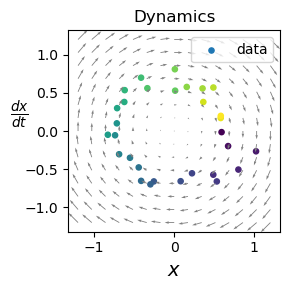

In [20]:
# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=100)

x, y, dx, dy, t = get_trajectory(radius=0.7, y0=np.array([1,0]))
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

In [21]:
base_model = HNN(hamiltonian=False)
path = '{}/{}.tar'.format(save_dir, 'spring-baseline')
base_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [22]:
hnn_model = HNN(hamiltonian=True)
path = '{}/{}.tar'.format(save_dir, 'spring-hnn')
hnn_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
solve_ivp = scipy.integrate.solve_ivp

In [24]:
gridsize = 10
# get their vector fields
field = get_field(gridsize=10)
base_field = get_vector_field(base_model, gridsize=gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1., 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

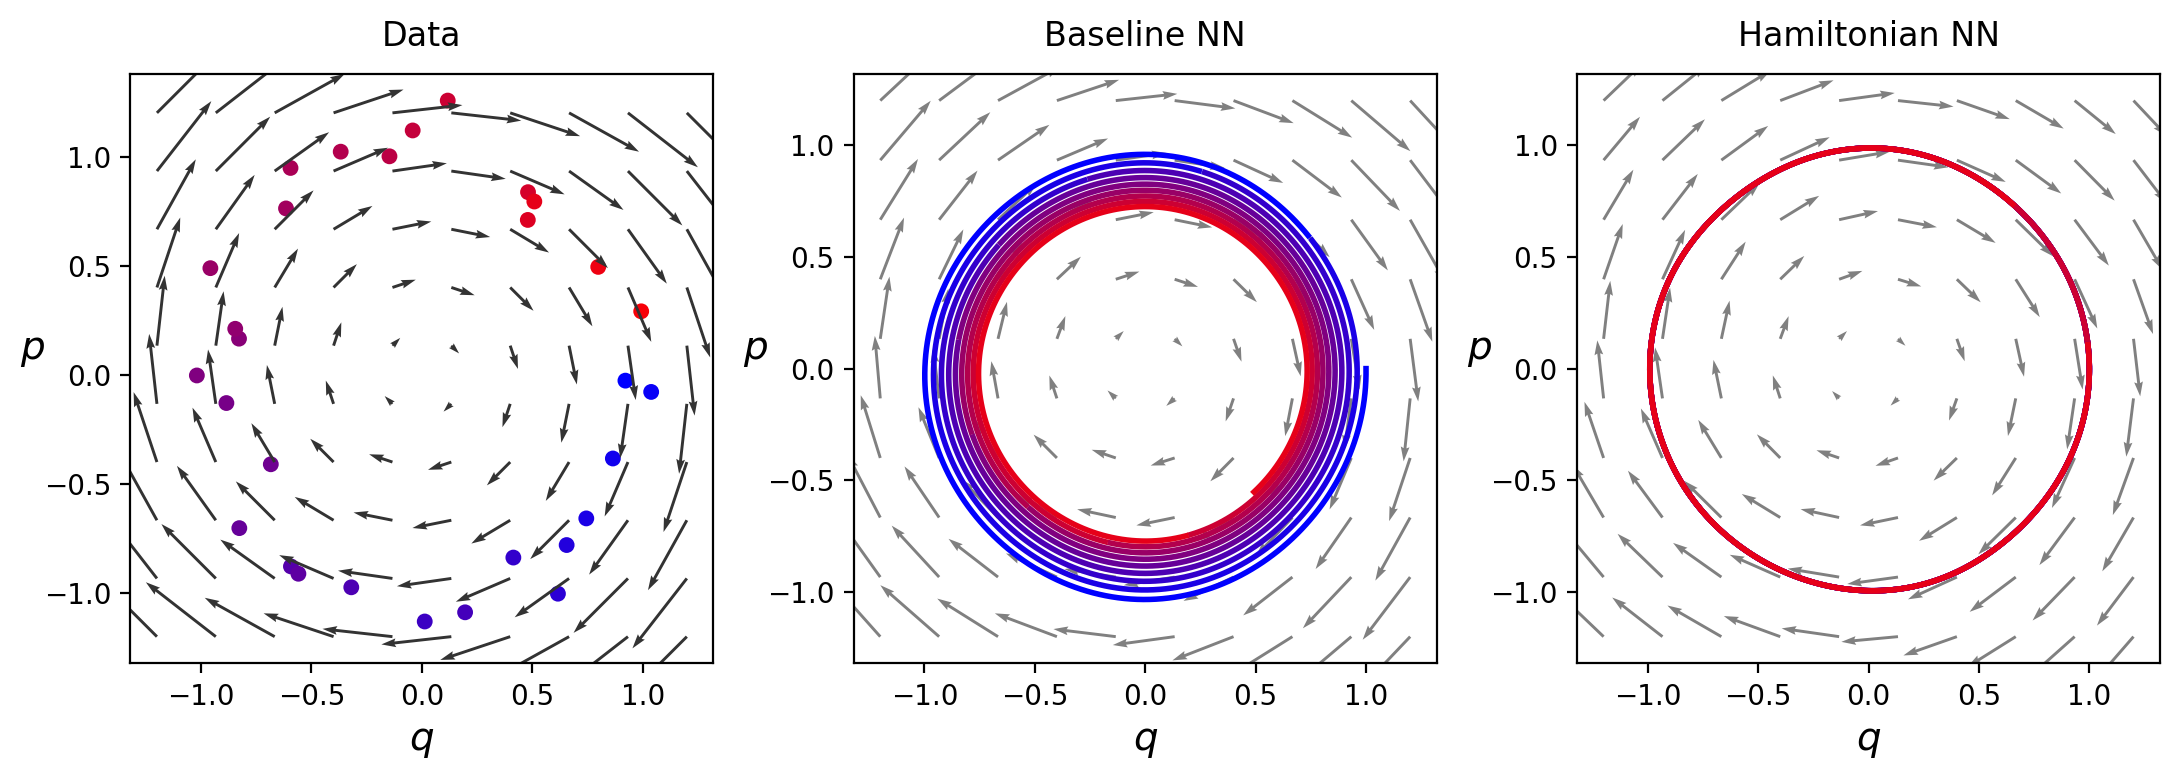

In [25]:
ARROW_SCALE = 20
ARROW_WIDTH = 0.005
LINE_SEGMENTS = 10 
LINE_WIDTH = 2

###### PLOT ######
fig = plt.figure(figsize=(11, 4), facecolor='white', dpi=200)

# plot dynamics
fig.add_subplot(1, 3, 1, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=1, y0=np.array([1,0]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 3, 2, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 3, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() ; plt.show()